Code for baseline originating from: https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3

In [1]:
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms
from torch.nn.functional import relu
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from skimage import io
import torch
from skimage import color
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.init as init
from PIL import Image, ImageOps
import pickle
from copy import deepcopy
import matplotlib.colors as mcolors

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('y')
else:
    device = torch.device('cpu')
    print('n')


y


In [3]:
class FashionDataset(Dataset):
    def __init__(self, csv_file, img_dir, segm_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.segm_dir = segm_dir
        self.transform = transform


    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir,
                                self.data_frame.iloc[idx, 0])

        segm_name = os.path.join(self.segm_dir,
                                self.data_frame.iloc[idx, -1])

        image = Image.open(img_name)
        label = Image.open(segm_name)


        #Convert to grayscale 
        # image = image.convert('L')
        
        #Resize image and label to 572x572
        image = image.resize((572, 572))
        label = label.resize((572, 572))

        #Crop label to match probability output from model
        crop = transforms.CenterCrop(388)
        label = crop(label)

        
        #Normalize the image
        image = np.asarray(image)
        min_image = np.min(image)
        max_image = np.max(image)
        image = (image - min_image)/(max_image - min_image + 1e-4)
        
        #Convert to tensors
        image = torch.tensor(np.array(image)).float().permute(2, 0, 1)
        label = torch.tensor(np.array(label)).long()

        #sample = {'x': , 'y': }
        sample = {'x': image, 'y': label}
    
        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [4]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=0) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=0) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=0) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=0) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=0) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=0) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=0) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=0) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=0) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=0) # output: 28x28x1024


        # Decoder        

        self.centercrop1 = transforms.CenterCrop(56)
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=0)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=0)

        self.centercrop2 = transforms.CenterCrop(104)
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=0)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=0)
        
        self.centercrop3 = transforms.CenterCrop(200)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=0)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=0)

        self.centercrop4 = transforms.CenterCrop(392)
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=0)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=0)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)


    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
       
        # Decoder
        xe42 = self.centercrop1(xe42) #ADDED
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xe32 = self.centercrop2(xe32) #ADDED
        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xe22 = self.centercrop3(xe22) #ADDED        
        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xe12 = self.centercrop4(xe12) #ADDED                
        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [5]:
def train_model(model, dataloader, optimizer, loss_fn, num_epochs, bs, verbose = False):
    loss_dict = {'train':[],'validate':[]}
    phases = ['train','validate']
    best_loss = 1e30
    since = time.time()
    for i in range(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs-1))
        print('-'*10)
        for p in phases:
            # running_correct = 0
            running_loss = 0
            running_total = 0
            if p == 'train':
                model.train()
            else:
                model.eval()
            for data in dataloader[p]:
                optimizer.zero_grad()            
                image = data['x'].to(device)
                label = data['y'].to(device)
                output = model(image)
                #print('hi')

                # output_flattened = output.permute(0, 2, 3, 1).contiguous().view(-1, 7)
                # label_flattened = label.view(-1).contiguous()  
                loss = loss_fn(output, label)     
                #print('hi')
                #print(output.shape)
                #reshaped_output = output.view(bs, 8, -1)
                reshaped_output = output.view(output.shape[0], 8, -1)
                _, preds = torch.max(reshaped_output, dim = 1)
                preds = preds.view(output.shape[0],388,388)
                num_imgs = image.size()[0]

                running_loss += loss.item()*num_imgs
                running_total += num_imgs
                
                if p== 'train':
                    loss.backward()
                    optimizer.step()
            epoch_loss = float(running_loss/running_total)
            if verbose or (i%10 == 0):
                print('Phase:{}, epoch loss: {:.4f}'.format(p, epoch_loss))

            loss_dict[p].append(epoch_loss)
            if p == 'validate':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    model.load_state_dict(best_model_wts)
    
    return model, loss_dict




In [6]:
def dice_score(y_true, y_pred, num_classes=7):
    dice_scores = []
    classes = np.unique(y_true)
    for class_id in classes:
        y_true_class = (y_true == class_id).astype(np.float32)
        y_pred_class = (y_pred == class_id).astype(np.float32)
        intersection = np.sum(y_true_class * y_pred_class)
        dice_score = (2. * intersection) / (np.sum(y_true_class) + np.sum(y_pred_class))
        dice_scores.append(dice_score)
    return np.mean(dice_scores)

In [7]:
def fill_pixels(matrix, threshold=0.8, diameter=10):

    matrix = matrix.float()

    # Define a kernel for 10-pixel diameter
    kernel_size = 2 * diameter + 1
    kernel = torch.ones(kernel_size, kernel_size).to(matrix.device)

    # Dilate the matrix using a max pooling operation
    dilated_matrix = F.max_pool2d(matrix.unsqueeze(0).unsqueeze(0), kernel_size=kernel_size, padding=diameter).squeeze()

    # Count the number of non-zero elements in the surrounding area
    non_zero_count = torch.sum(dilated_matrix > 0, dim=(0, 1))

    # Fill pixels where surrounded by non-zero values
    result_matrix = torch.where(non_zero_count / (kernel_size * kernel_size) >= threshold, dilated_matrix, matrix)

    return result_matrix

## Baseline for 15 Epochs, BS = 16, LR = Default

In [12]:
bs = 16

torch.cuda.empty_cache()

current_directory = os.getcwd()
data_directory = os.path.join(current_directory, '..', 'data')

dataset = {'train': FashionDataset(os.path.join(data_directory, 'segmentation_train.csv'),'/vast/amr10211/cv_data/images', '/vast/amr10211/cv_data/segm_preprocessed'), 
           'validate': FashionDataset(os.path.join(data_directory, 'segmentation_val.csv'),'/vast/amr10211/cv_data/images', '/vast/amr10211/cv_data/segm_preprocessed'), 
           'test': FashionDataset(os.path.join(data_directory, 'segmentation_test.csv'),'/vast/amr10211/cv_data/images', '/vast/amr10211/cv_data/segm_preprocessed')}
dataloader = {x: DataLoader(dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate']}

model = UNet(n_class = 8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [13]:
model, loss_dict = train_model(model, dataloader, optimizer, loss_fn=criterion, num_epochs=15, bs=bs, verbose=True)

Epoch: 0/14
----------
Phase:train, epoch loss: 0.7901
Phase:validate, epoch loss: 0.7599
Epoch: 1/14
----------
Phase:train, epoch loss: 0.7252
Phase:validate, epoch loss: 0.7681
Epoch: 2/14
----------
Phase:train, epoch loss: 0.7152
Phase:validate, epoch loss: 0.7839
Epoch: 3/14
----------
Phase:train, epoch loss: 0.6850
Phase:validate, epoch loss: 0.6475
Epoch: 4/14
----------
Phase:train, epoch loss: 0.6153
Phase:validate, epoch loss: 0.5910
Epoch: 5/14
----------
Phase:train, epoch loss: 0.5589
Phase:validate, epoch loss: 0.7276
Epoch: 6/14
----------
Phase:train, epoch loss: 0.5728
Phase:validate, epoch loss: 0.5626
Epoch: 7/14
----------
Phase:train, epoch loss: 0.5360
Phase:validate, epoch loss: 0.5540
Epoch: 8/14
----------
Phase:train, epoch loss: 0.5268
Phase:validate, epoch loss: 0.5577
Epoch: 9/14
----------
Phase:train, epoch loss: 0.5833
Phase:validate, epoch loss: 0.5558
Epoch: 10/14
----------
Phase:train, epoch loss: 0.5242
Phase:validate, epoch loss: 0.5445
Epoch: 11

In [14]:
torch.save(model, 'baseline_segmentation_model_15_epochs_lr_0.001.pth')

with open('baseline_segmentation_model_15_epochs_lr_0.001.pkl', 'wb') as f:
    pickle.dump(loss_dict, f)

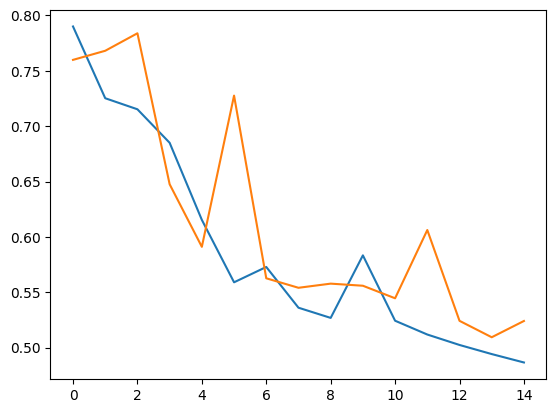

In [15]:
plt.plot(np.arange(0,15), loss_dict['train'])
plt.plot(np.arange(0,15), loss_dict['validate'])

In [16]:
model = torch.load('baseline_segmentation_model_15_epochs_lr_0.001.pth')
bs = 16
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

current_directory = os.getcwd()
data_directory = os.path.join(current_directory, '..', 'data')

dataset = {'test': FashionDataset(os.path.join(data_directory, 'segmentation_test.csv'),'/vast/amr10211/cv_data/images', '/vast/amr10211/cv_data/segm_preprocessed')}
dataloader = {x: DataLoader(dataset[x], batch_size=bs,
                        shuffle=False, num_workers=0) for x in ['test']}


In [17]:
model.eval()
dice_scores = []
for data in dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = model(image)
    loss = loss_fn(output, label)     
    reshaped_output = output.view(output.shape[0], 8, -1)
    _, pred = torch.max(reshaped_output, dim = 1)
    pred = pred.view(output.shape[0],388,388)
    for img, lab in zip(pred, label):
        #lab = fill_pixels(lab)
        dice = dice_score(lab.cpu().numpy(), img.cpu().numpy())
        dice_scores.append(dice)


In [18]:
avg_dice_score = np.mean(dice_scores)
print('Average Dice Score:', avg_dice_score)

Average Dice Score: 0.3829092155871745


### Full Data for 50 Epochs, BS = 16, LR = 0.0001

In [7]:
with open('segmentation_model_50_epochs_lr_0.0001.pkl', 'rb') as f:
    loss_dict = pickle.load(f)

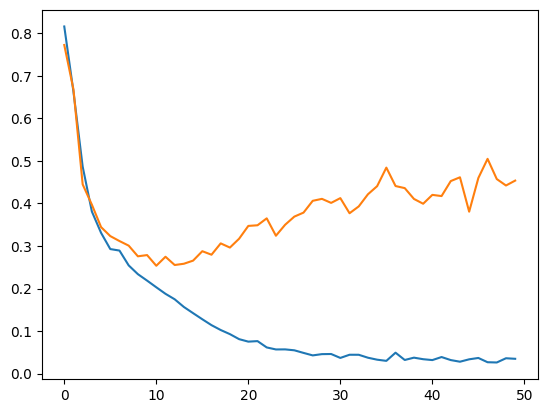

In [9]:
plt.plot(np.arange(0,50), loss_dict['train'])
plt.plot(np.arange(0,50), loss_dict['validate'])

In [8]:
model = torch.load('segmentation_model_50_epochs_lr_0.0001.pth')
bs = 16
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

current_directory = os.getcwd()
data_directory = os.path.join(current_directory, '..', 'data')

dataset = {'test': FashionDataset(os.path.join(data_directory, 'segmentation_test.csv'),'/vast/amr10211/cv_data/images', '/vast/amr10211/cv_data/segm_preprocessed')}
dataloader = {x: DataLoader(dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['test']}


In [11]:
model.eval()
dice_scores = []
for data in dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = model(image)
    loss = loss_fn(output, label)     
    reshaped_output = output.view(output.shape[0], 8, -1)
    _, pred = torch.max(reshaped_output, dim = 1)
    pred = pred.view(output.shape[0],388,388)
    for img, lab in zip(pred, label):
        #lab = fill_pixels(lab)
        dice = dice_score(lab.cpu().numpy(), img.cpu().numpy())
        dice_scores.append(dice)

avg_dice_score = np.mean(dice_scores)
print('Average Dice Score:', avg_dice_score)

Average Dice Score: 0.5081676536647011


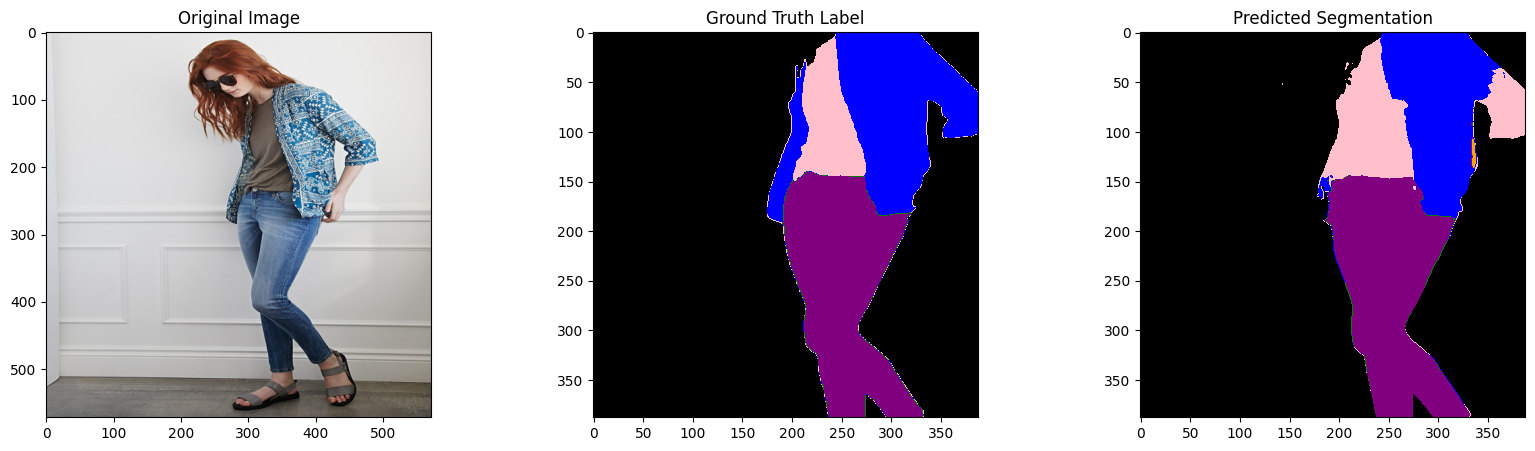

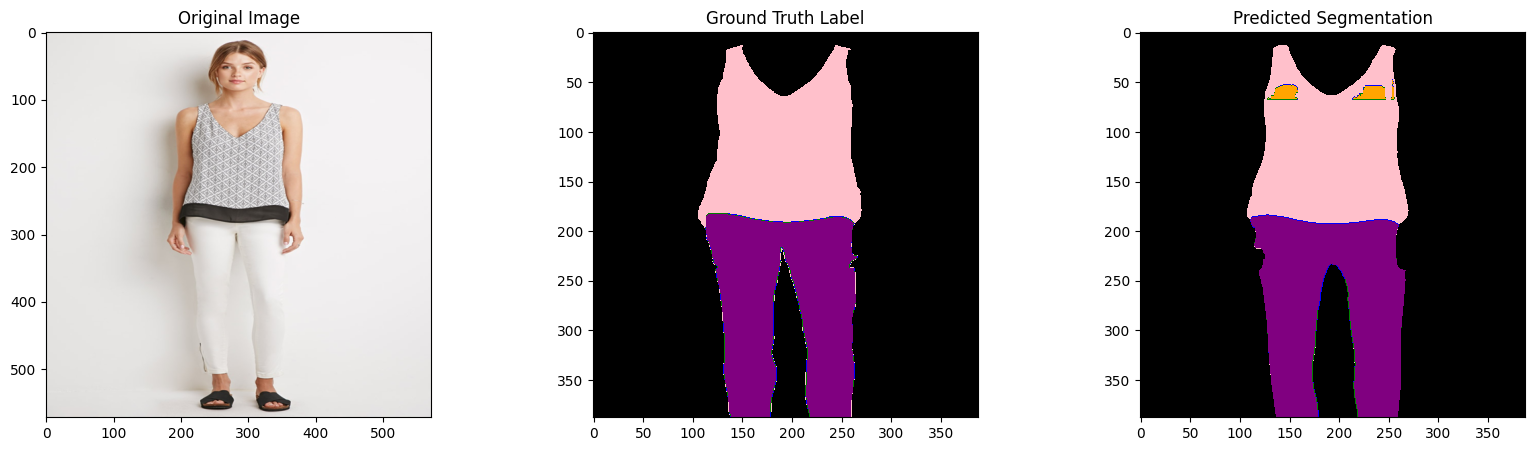

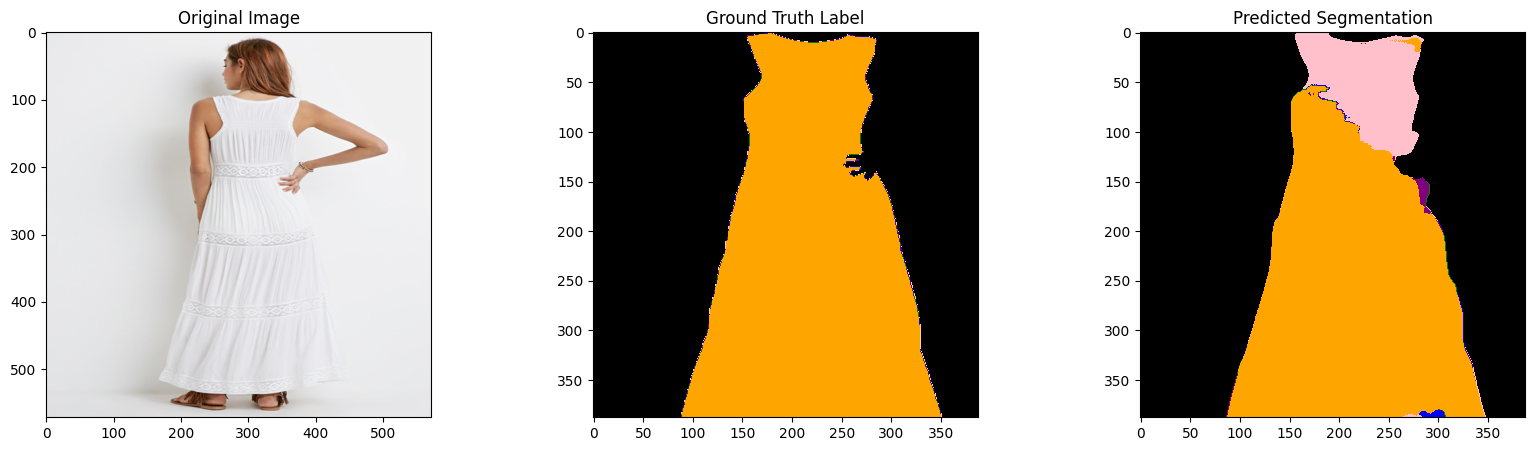

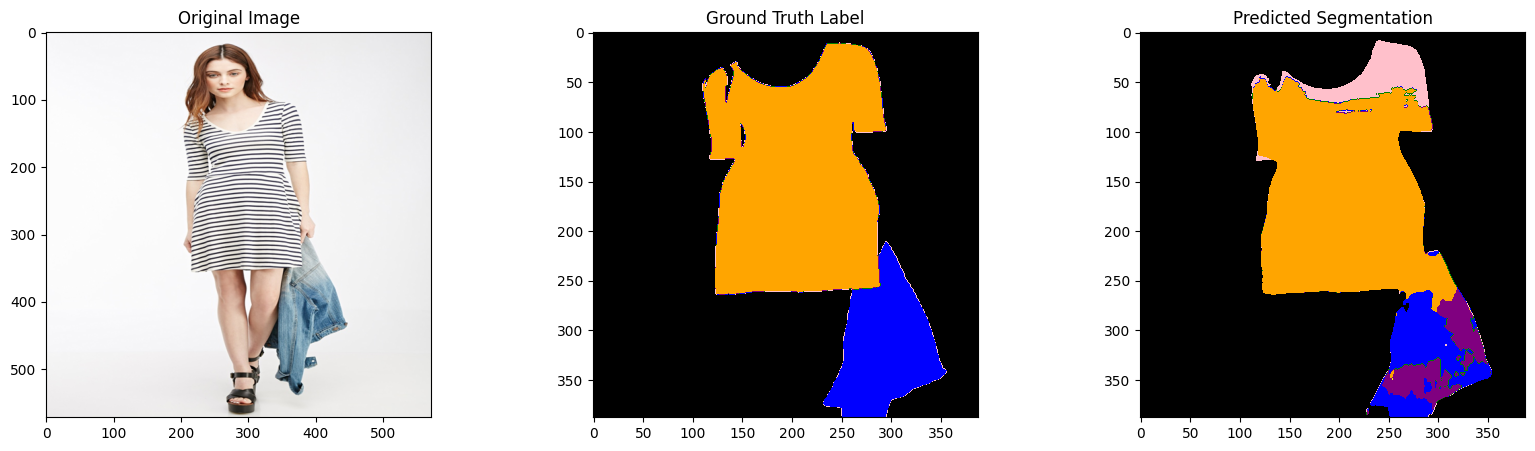

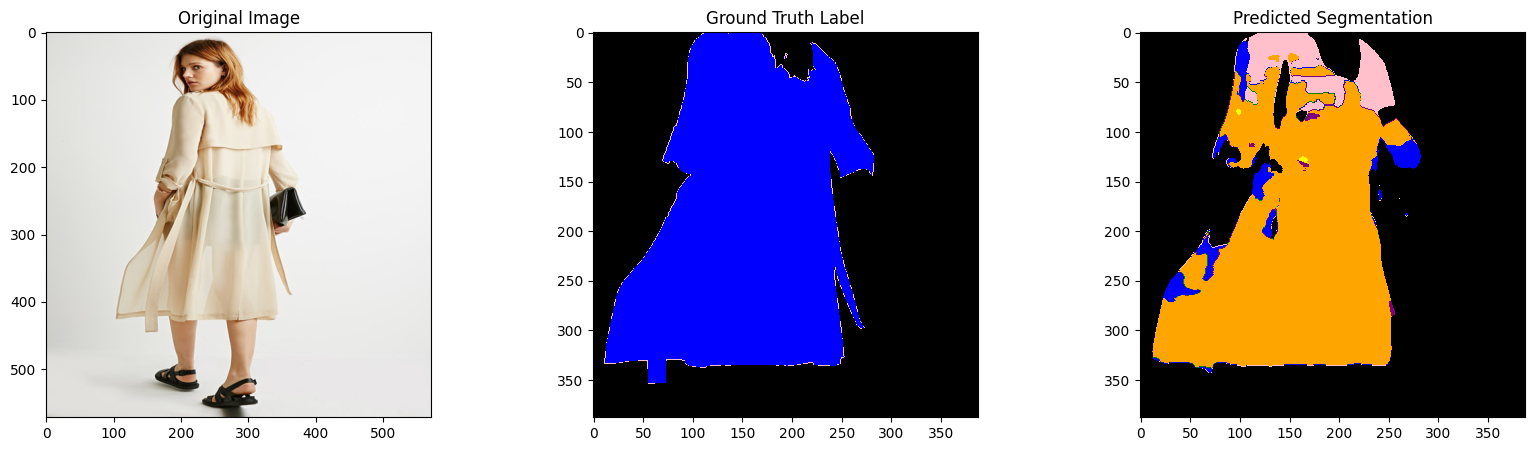

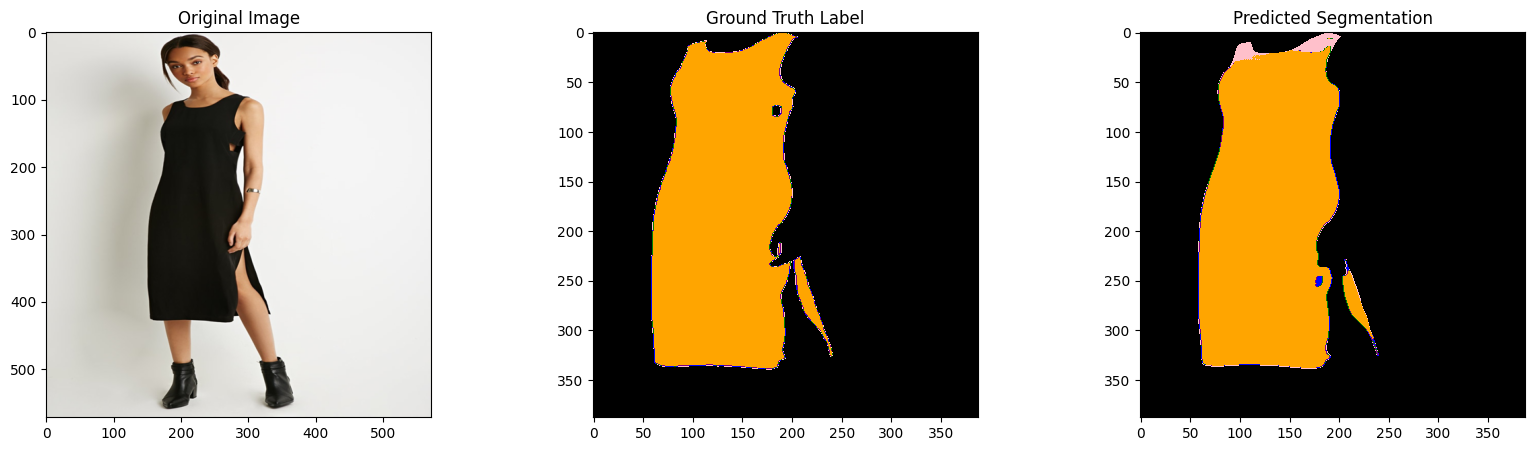

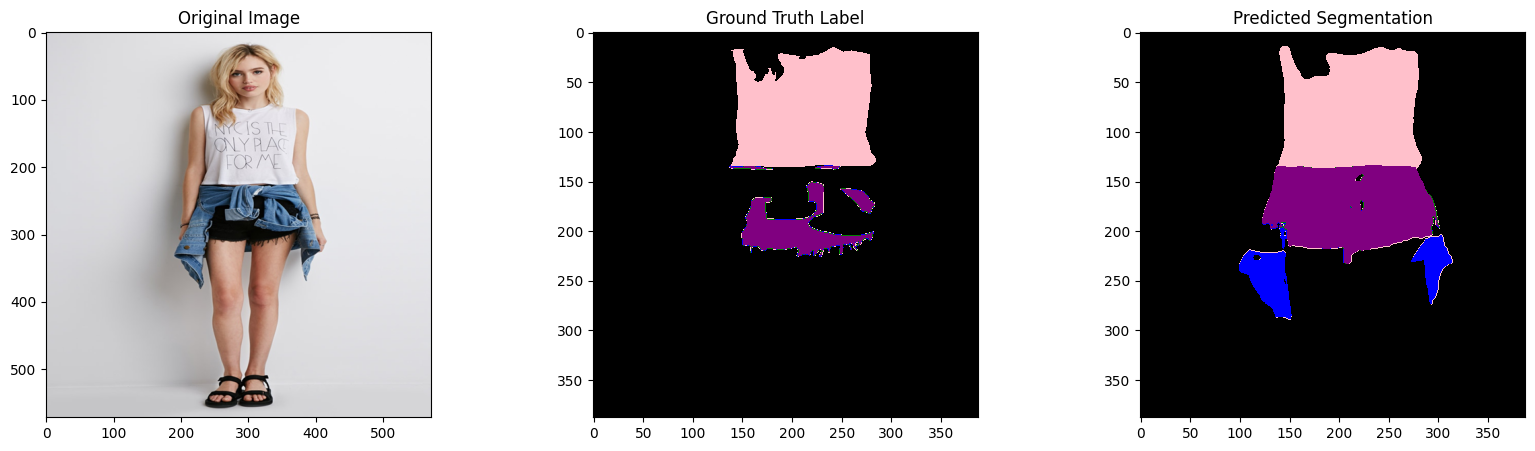

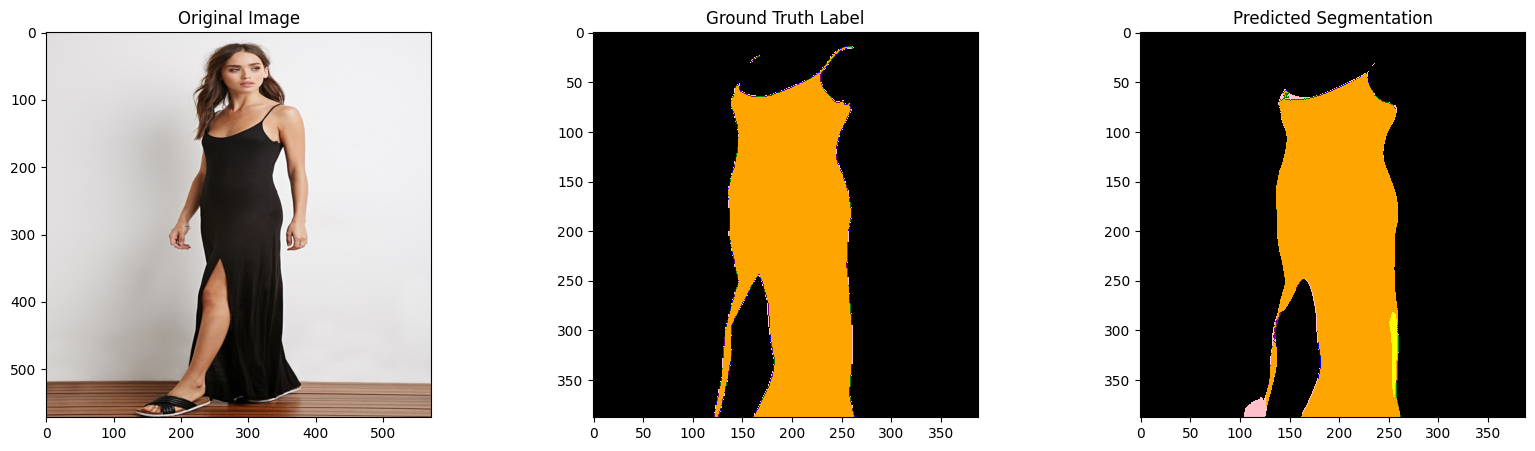

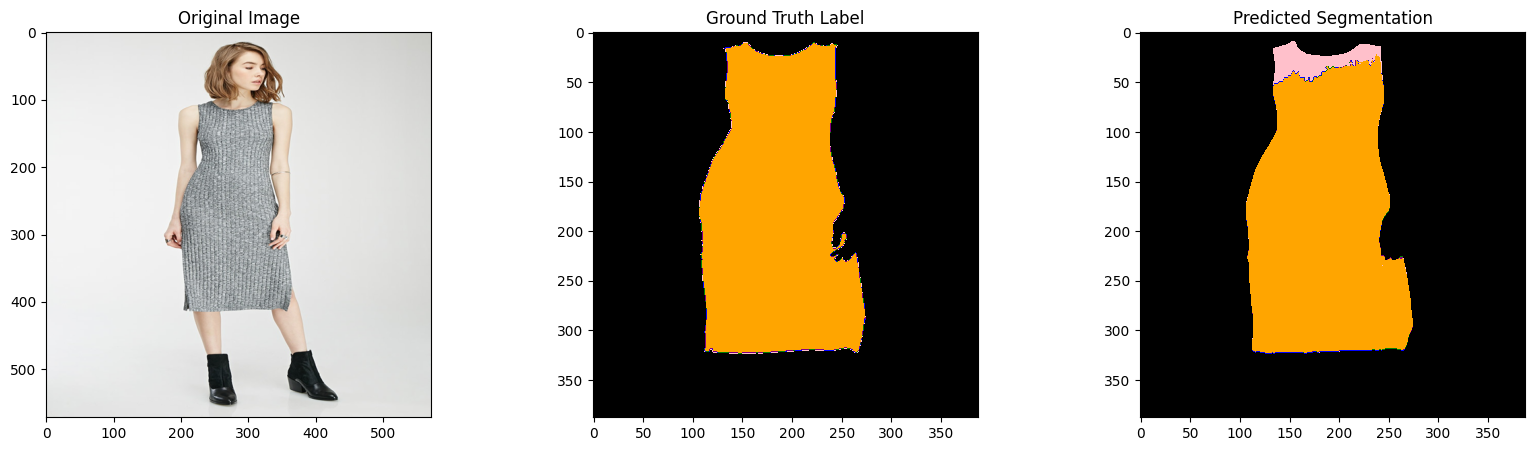

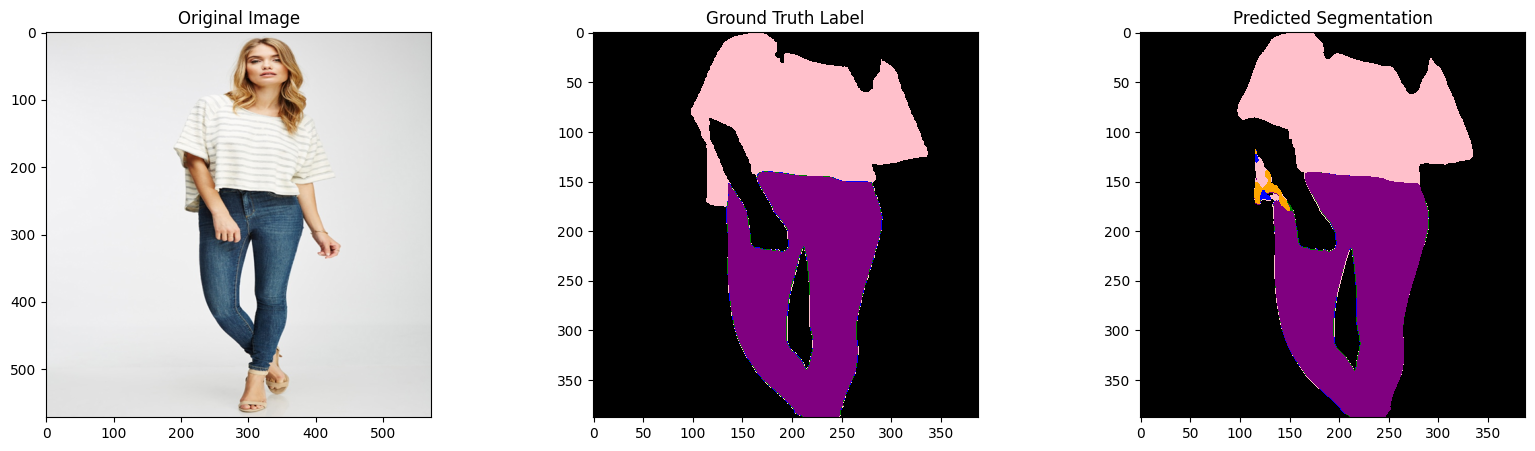

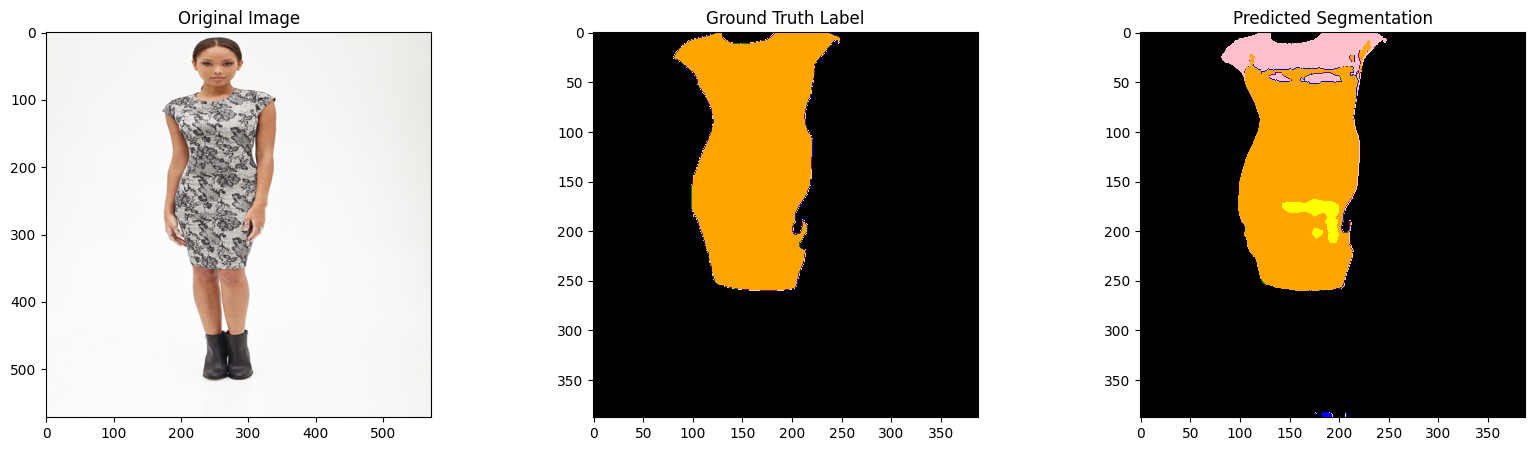

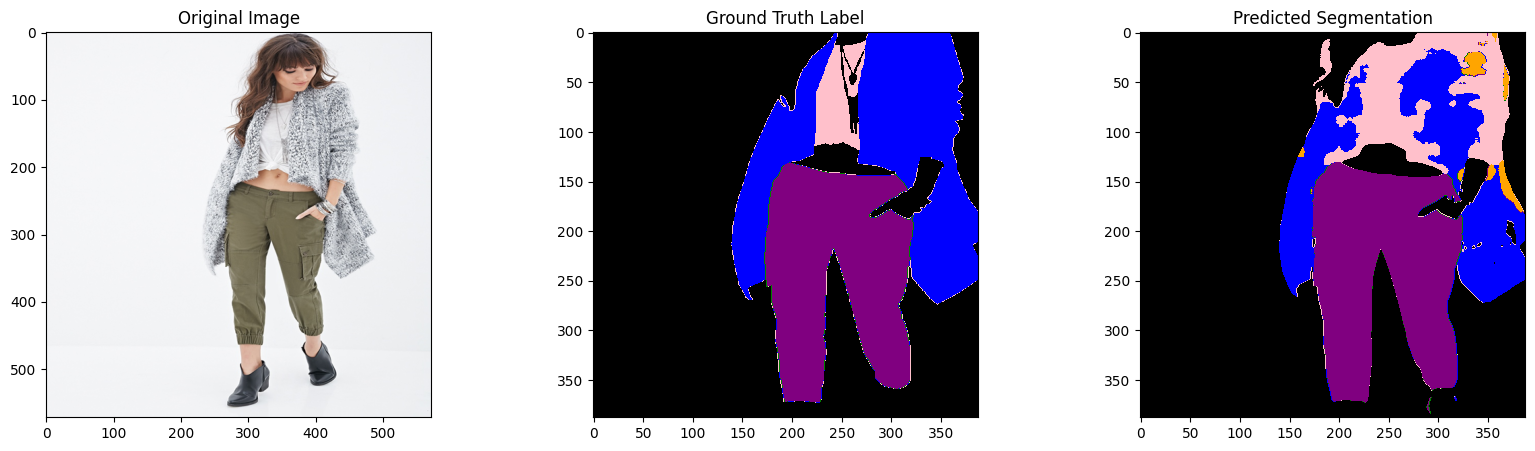

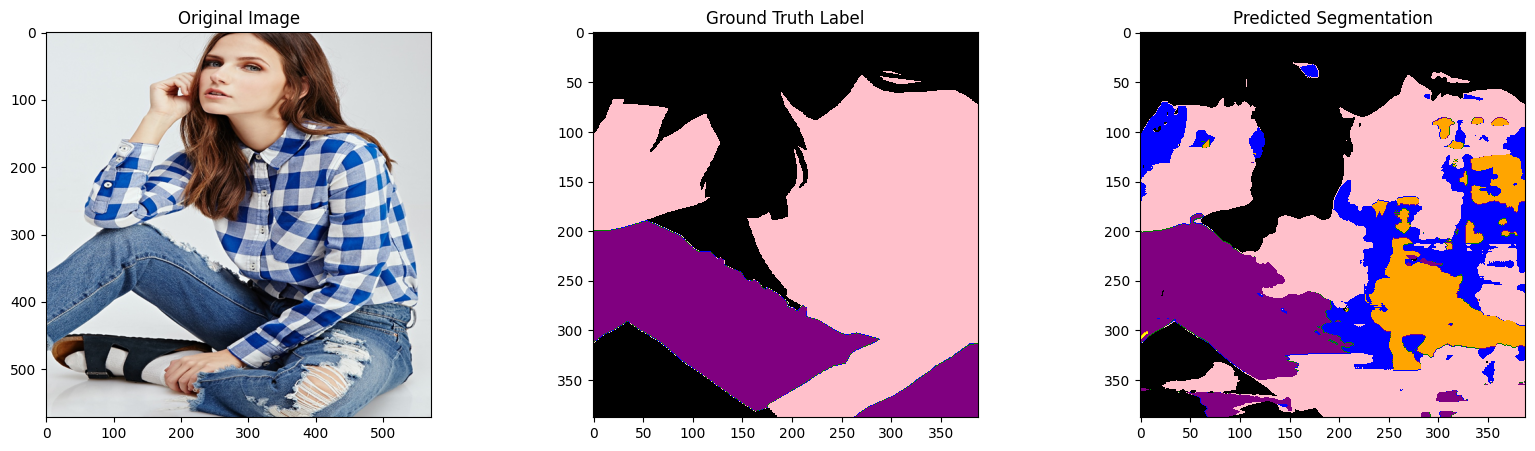

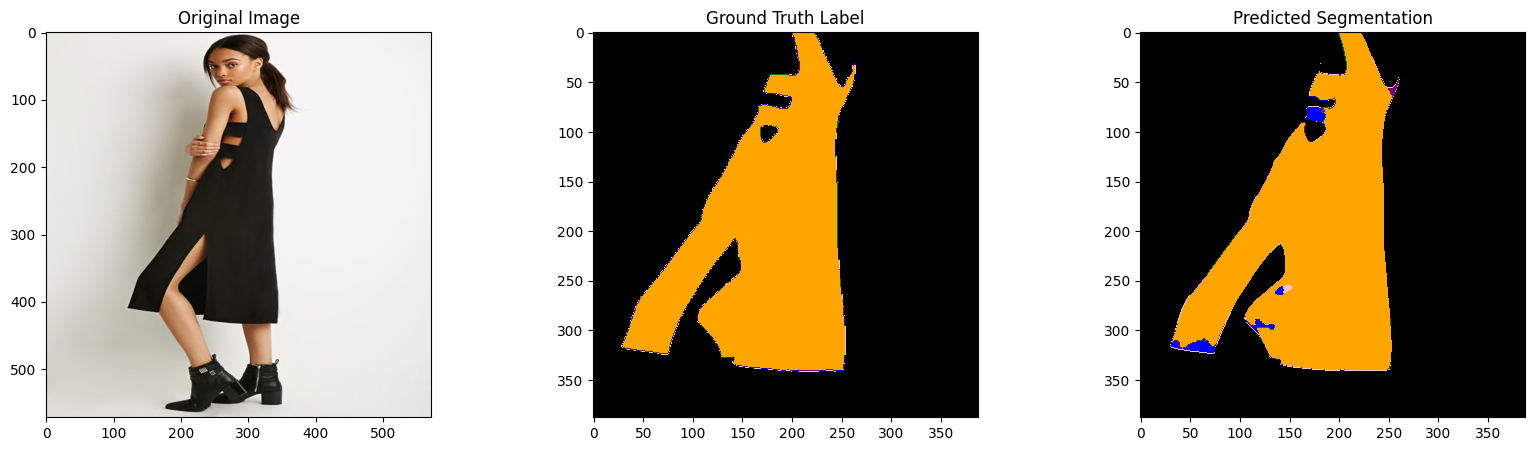

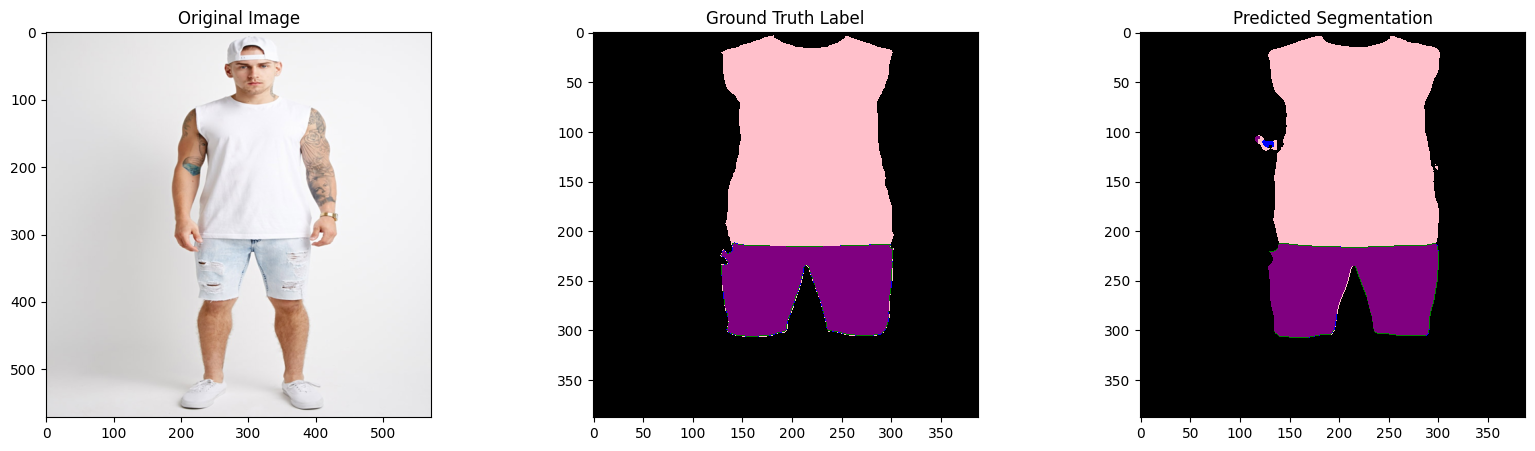

In [46]:
num_labels = 8
custom_cmap = mcolors.ListedColormap(['black', 'pink', 'blue', 'green', 'purple', 'orange', 'yellow', 'cyan'])

model.eval()
example_count = 0

for data in dataloader['test']:
    optimizer.zero_grad()            
    images = data['x'].to(device)
    labels = data['y'].to(device)
    outputs = model(images)
    losses = loss_fn(outputs, labels)     
    reshaped_outputs = outputs.view(outputs.shape[0], 8, -1)
    _, preds = torch.max(reshaped_outputs, dim=1)
    preds = preds.view(outputs.shape[0], 388, 388)
    for i, (img, lab, pred_mask) in enumerate(zip(images.cpu(), labels.cpu(), preds.cpu())):
        fig, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(img.permute(1, 2, 0))
        axes[0].set_title('Original Image')
        
        axes[1].imshow(lab.numpy(), cmap=custom_cmap, norm=mcolors.Normalize(vmin=0, vmax=num_labels-1))
        axes[1].set_title('Ground Truth Label')
        
        axes[2].imshow(pred_mask.numpy(), cmap=custom_cmap, norm=mcolors.Normalize(vmin=0, vmax=num_labels-1))
        axes[2].set_title('Predicted Segmentation')
        
        # filename = f"output_{i}.png"
        # plt.savefig(filename)
        
        plt.show()
        
        example_count += 1
        if example_count == 15:
            break
    if example_count == 15:
        break
